# **Fashion Article Classification using ANN**

### Importing the Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.datasets import fashion_mnist


### Loading the dataet

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 31s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


### Exploring the Data

In [3]:
print("Training data shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)
print("\nPixel value range - Min:", train_images.min(), "Max:", train_images.max())
print("Unique label values:", np.unique(train_labels))

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)

Pixel value range - Min: 0 Max: 255
Unique label values: [0 1 2 3 4 5 6 7 8 9]


### Define class names for plotting
Each index corresponds to the integer label in the dataset

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualizing some samples

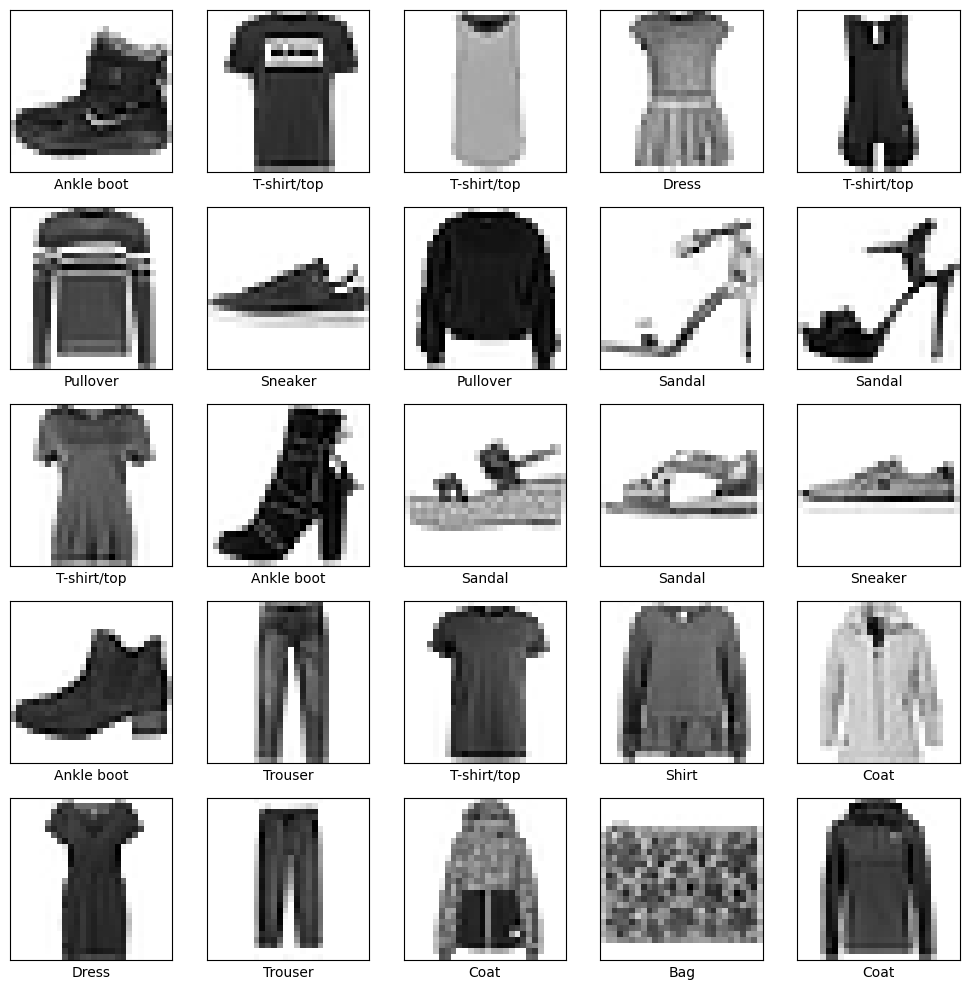

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.tight_layout()
plt.show()

### Preprocessing

1. Normalization 

In [7]:
train_images = train_images.astype(float)/255.0
test_images = test_images.astype(float)/255.0

2. Reshaping ==>>  Flatten the 28x28 images into 1D arrays of 784 pixels

In [8]:
train_images_flat = train_images.reshape((-1, 28*28))
test_images_flat = test_images.reshape((-1, 28*28))

Printing the new to verify

In [9]:
print("Training data shape after flattening:", train_images_flat.shape)
print("Testing data shape after flattening:", test_images_flat.shape)

Training data shape after flattening: (60000, 784)
Testing data shape after flattening: (10000, 784)


3. Label Encoding

In [10]:
from keras.utils import to_categorical

train_labels_one_hot = to_categorical(train_labels, num_classes=10)
test_labels_one_hot = to_categorical(test_labels, num_classes=10)

In [11]:
# Print the original and encoded label for the first sample to verify
print(f"Original label: {train_labels[0]}")
print(f"One-hot encoded label: {train_labels_one_hot[0]}")

Original label: 9
One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### **Building the Neural Network**

In [15]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()

    num_layers = hp.Int('num_layers', min_value=1, max_value=10)
    for i in range(num_layers):
        if i == 0: # first layer
            model.add(
                Dense(
                    hp.Int('nodes_'+str(i), min_value=32, max_value=256, step=32),
                    activation= hp.Choice('activation_'+str(1), values=['relu', 'tanh', 'sigmoid', 'softmax']),
                    input_shape=(784,)
                )
            )
            model.add(Dropout(hp.Choice('dropout_'+str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        else: # Hidden layers
            model.add(
                Dense(
                    hp.Int('nodes_'+str(i), min_value=32, max_value=256, step=32),
                    activation= hp.Choice('activation_'+str(1), values=['relu', 'tanh', 'sigmoid', 'softmax'])
                )
            )
            model.add(Dropout(hp.Choice('dropout_'+str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))

    model.add(Dense(10, activation='softmax')) # last layer

    optimizers = hp.Choice('optimizer', values=['adam', 'rmsprop', 'nadam', 'sgd', 'adadelta'])
    loss = hp.Choice('loss', values=['binary_crossentropy', 'categorical_crossentropy', 'sparse_categorical_crossentropy'])
    model.compile(optimizer=optimizers, loss=loss, metrics=['accuracy'])

    return model       


In [16]:
tuner = kt.RandomSearch(build_model, 
                        objective='val_accuracy',
                        max_trials=5,
                        directory='KerasTunerCache',
                        project_name='FAC')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
tuner.search(
    train_images_flat, train_labels_one_hot,
    epochs=10,
    validation_data=(test_images_flat, test_labels_one_hot)    
    )

Trial 5 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.853600025177002
Total elapsed time: 00h 04m 15s


In [18]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 4,
 'nodes_0': 64,
 'activation_1': 'relu',
 'dropout_0': 0.5,
 'optimizer': 'nadam',
 'loss': 'categorical_crossentropy',
 'nodes_1': 32,
 'dropout_1': 0.1,
 'nodes_2': 32,
 'dropout_2': 0.1,
 'nodes_3': 32,
 'dropout_3': 0.1}

In [19]:
model = tuner.get_best_models(num_models=1)[0]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 23 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### **Training the Model**

In [22]:
history = model.fit(
    train_images_flat, train_labels_one_hot,
    batch_size=64,
    epochs=20,
    # Use 10% of the training data as validation data
    validation_split=0.1,
    # This prints a progress bar for each epoch
    verbose=1
)


Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8265 - loss: 0.4870 - val_accuracy: 0.8560 - val_loss: 0.3827
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8267 - loss: 0.4853 - val_accuracy: 0.8627 - val_loss: 0.3775
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8277 - loss: 0.4778 - val_accuracy: 0.8630 - val_loss: 0.3759
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8295 - loss: 0.4784 - val_accuracy: 0.8610 - val_loss: 0.3878
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8319 - loss: 0.4738 - val_accuracy: 0.8635 - val_loss: 0.3697
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8313 - loss: 0.4717 - val_accuracy: 0.8632 - val_loss: 0.3676
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8336 - loss: 0.4671 - val_accuracy: 0.8637 - val_loss: 0.3729
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8359 - loss: 0.4626 - val_accuracy: 0.

### Plot the Training History

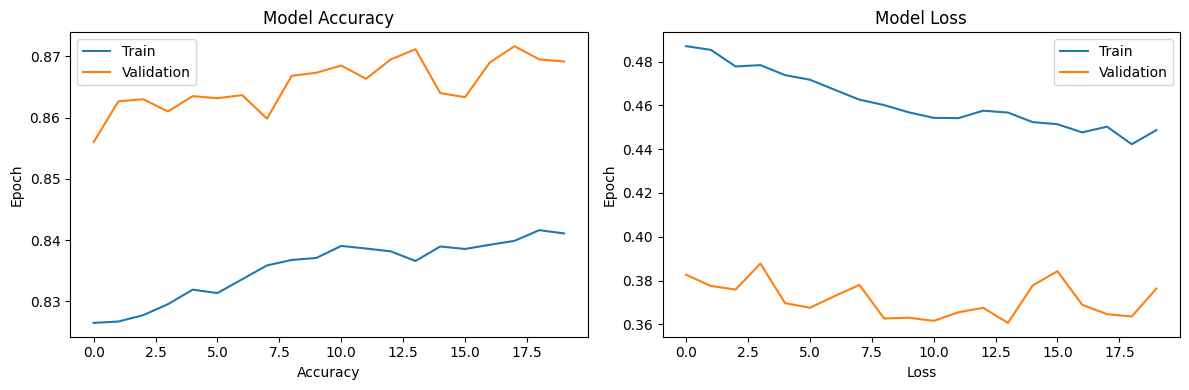

In [27]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Loss")
plt.ylabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## **Evaluation and Analysis**

Evaluate on Test Data

In [28]:
test_loss, test_accuracy = model.evaluate(test_images_flat, test_labels_one_hot, verbose=0)
print(f'\nFinal Test Loss: {test_loss:.4f}')
print(f'Final Test Accuracy: {test_accuracy:.4f}')


Final Test Loss: 0.3991
Final Test Accuracy: 0.8628



Make Predictions

In [29]:
predictions = model.predict(test_images_flat)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [30]:
predictions.shape

(10000, 10)

Analyze Results

In [31]:
predicted_labels = np.argmax(predictions, axis=1)

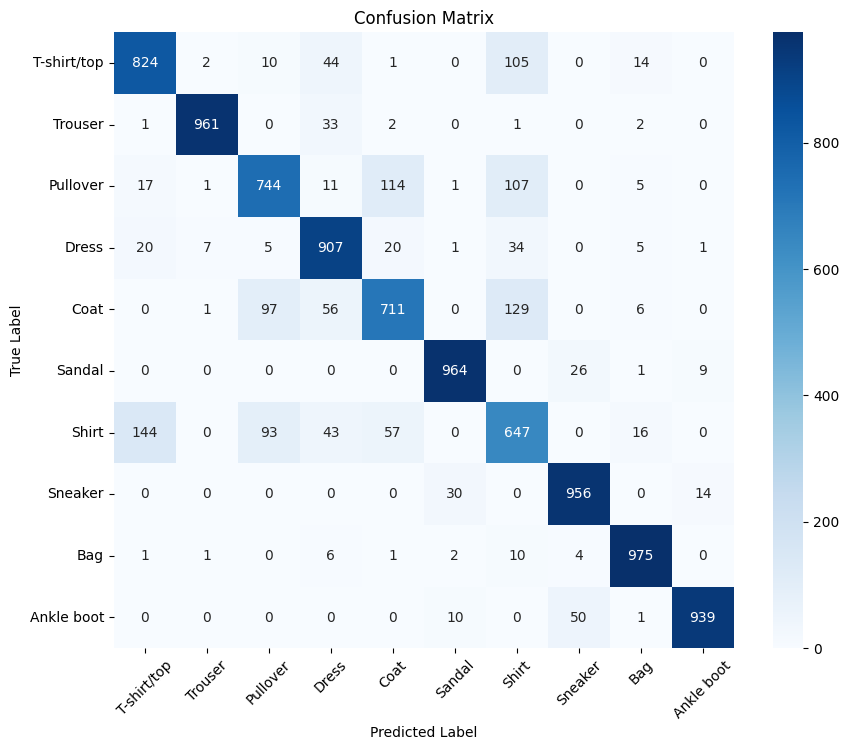

In [33]:
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Print the classification accuracy and ` Visualizing Correct vs Incorrect Predictions`

Accuracy from predictions: 0.8628


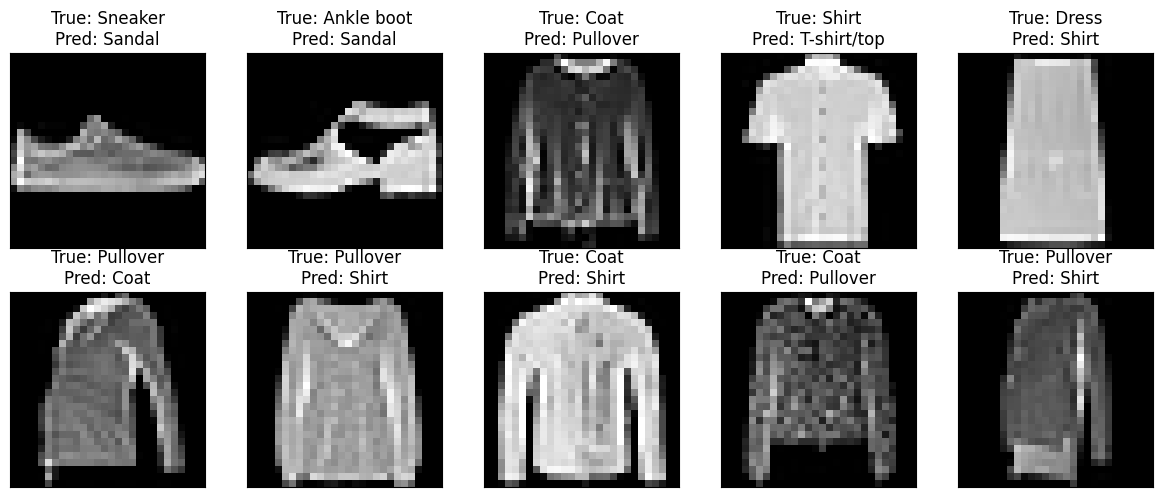


Misclassifications for 'Shirt' (class 6):
  - Frequently confused as 'T-shirt/top': 144 times
  - Frequently confused as 'Pullover': 93 times
  - Frequently confused as 'Dress': 43 times
  - Frequently confused as 'Coat': 57 times
  - Frequently confused as 'Bag': 16 times


In [35]:
# This should match the test_accuracy from model.evaluate()
print(f"Accuracy from predictions: {accuracy_score(test_labels, predicted_labels):.4f}")

# Visualizing Correct vs Incorrect Predictions ---
incorrect_indices = np.where(predicted_labels != test_labels)[0]

# Plot some of the misclassified images
plt.figure(figsize=(12, 5))
for i, incorrect in enumerate(incorrect_indices[:10]): # Show first 10 errors
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[incorrect], cmap='gray', interpolation='none')
    plt.title(f"True: {class_names[test_labels[incorrect]]}\nPred: {class_names[predicted_labels[incorrect]]}")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

shirt_index = 6
shirt_misclassifications = cm[shirt_index, :]
print(f"\nMisclassifications for 'Shirt' (class 6):")
for i, count in enumerate(shirt_misclassifications):
    if i != shirt_index and count > 0:
        print(f"  - Frequently confused as '{class_names[i]}': {count} times")

### **CONCLUSION**
* This analysis clearly shows the weakness of the ANN. It struggles with fine-grained visual details and spatial relationships. It's good at telling broadly different categories apart (e.g., a Bag vs a Sandal) but fails on subtler distinctions. This perfectly sets the stage for CNNs, which are designed to understand spatial hierarchies and patterns like edges, textures, and shapes.